In [ ]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import json


config = json.load(open('../config.json'))
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [3]:
existing_studies = vis2D.existing_studies_df()

In [13]:
# For each study, fit a line to Preferred period (deg) as a function of Eccentricity
fit_df = vis2D.fit_study_lines(existing_studies)
fit_df


,Paper,slope,intercept,r_value,n_points
0,Aghajari (2020),0.115781,0.454175,0.965800,9
1,D'Souza (2016),0.241976,0.076468,0.993261,3
2,Farivar (2017),0.133333,0.266667,1.000000,2
3,Henriksson (2008),0.274034,0.276043,0.995830,5
4,"Hess (dominant eye, 2009)",0.015801,0.421888,0.937395,3
5,Kay (2011),0.065370,0.054021,0.980545,5
6,Sasaki (2001),0.136204,1.023166,0.953542,7


In [38]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures')
lr = 0.0005
max_epoch = 30000
roi_list = ['V1']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi']
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in  [3,2,0]]
roi_pal.insert(0, (0.3,0.3,0.3))
stim_classes=['annulus', 'pinwheel', 'forward spiral','reverse spiral']
goal='replication'

pt_file_list = []
for subj, roi in itertools.product(nsd_subj_list, ['V1']):
    file_name = os.path.join(output_dir, 'sfp_model', 'results_2D', 'nsdsyn', 'corrected',
                             f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

nsd_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision',f'precision-s_dset-nsdsyn_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_params, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])
pt_file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = os.path.join(output_dir,'sfp_model', 'results_2D', 'broderick','corrected', f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
broderick_params = model.load_all_models(pt_file_list, *ARGS_2D)

broderick_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'broderick', 'precision','corrected', f'precision-s_dset-broderick_vs-pRFsize.csv'))
broderick_df = pd.merge(broderick_params, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_params = pd.concat((broderick_df, nsd_df), axis=0)

In [39]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
for subj, roi, frame in itertools.product(nsd_subj_list, ['V1'], ['scaled']):
    file_name = os.path.join(output_dir, 'sfp_model', 'prediction_2D', 'nsdsyn', 'corrected',
                             f'sfstimuli-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
nsd_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['sfstimuli'])

nsd_df = pd.merge(nsd_prediction, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
for subj, roi, frame in itertools.product(broderick_subj_list, ['V1'], ['scaled']):
    file_name = os.path.join(output_dir,  'sfp_model', 'prediction_2D', 'broderick', 'corrected',
                             f'sfstimuli-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
broderick_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['sfstimuli'])

broderick_df = pd.merge(broderick_prediction, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_df = pd.concat((broderick_df, nsd_df), axis=0)

In [56]:
ecc_list=[0,10]
ecc_df = final_df.query('sfstimuli == "scaled" & eccentricity in @ecc_list')
ecc_df = ecc_df.groupby(['sub','dset_type','vroinames','eccentricity']).mean().reset_index()


<AxesSubplot:xlabel='Eccentricity (deg)', ylabel='Preferred period (deg)'>

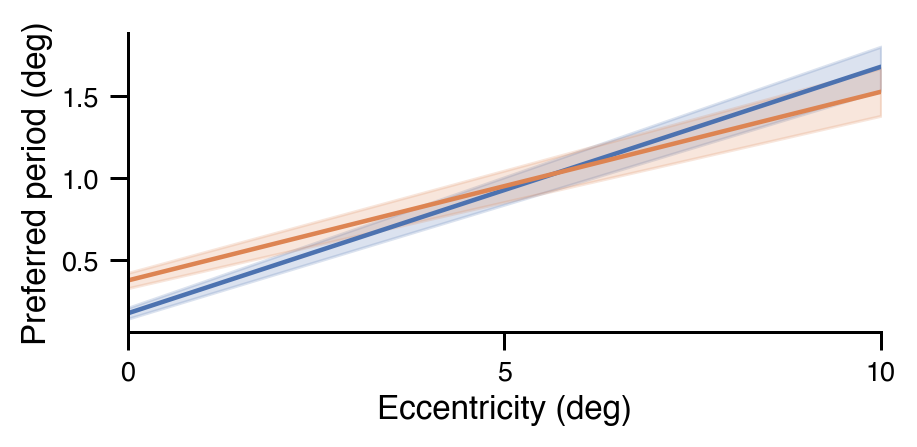

In [61]:
fig, ax = plt.subplots(figsize=(4.5, 1.8))
vis2D.plot_preferred_period_in_axes(ecc_df, x='eccentricity', y='Pv', ax=ax, hue='dset_type')

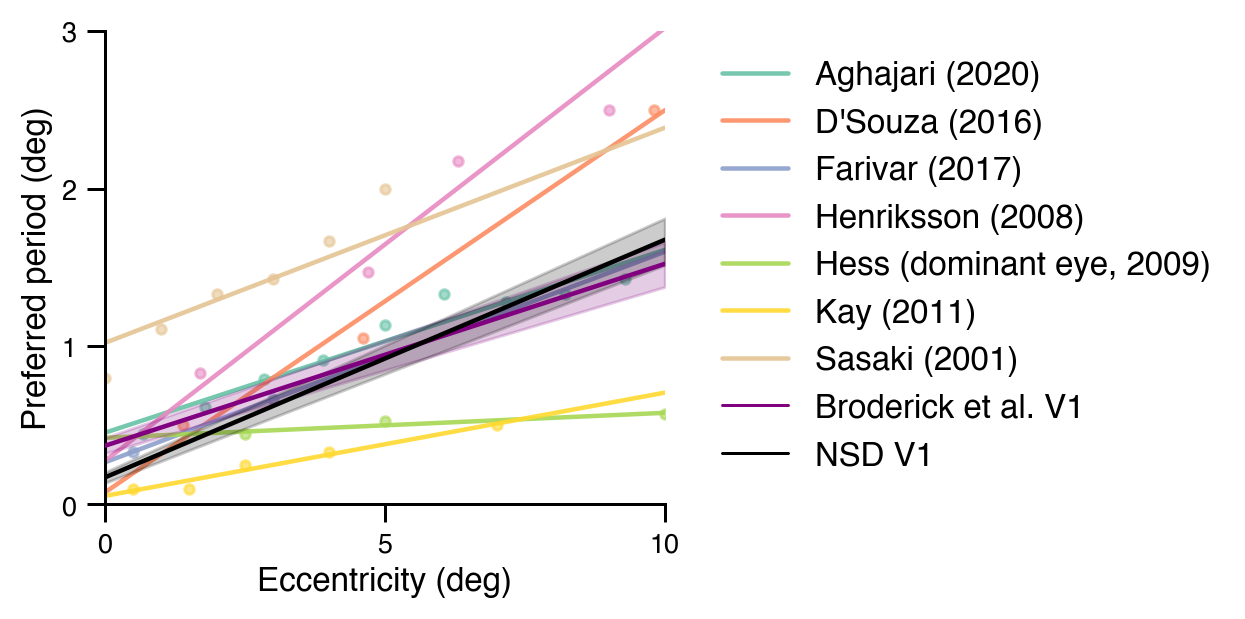

In [81]:
merged_df = pd.merge(existing_studies, fit_df, on='Paper')
fig, ax = vis2D.plot_preferred_period_vs_eccentricity_for_existing_studies(merged_df, ecc_df)


In [ ]:
dict(zip(merged_df['Paper'].unique(), palette))

In [20]:
sns.color_palette('tab10', 10)


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
Aghajari (2020) → teal-green (#1f77b4 / tab:blue)

D’Souza (2016) → orange (#ff7f0e / tab:orange)

Farivar (2017) → blue-purple (#2ca02c / tab:green)

Henriksson (2008) → pinkish-purple (#d62728 / tab:red)

Hess (dominant eye, 20xx) → lime-green (#9467bd / tab:purple)

Kay (2011) → yellow (#bcbd22 / tab:olive)

Sasaki (2001) → beige-brown (#8c564b / tab:brown)